<a href="https://colab.research.google.com/github/lucarenz1997/recommender_systems/blob/main/Hybrid-NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Neural Collaborative Filtering (NCF) Model
**Authors** : Rafaella and Luca

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import warnings
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Suppress all warnings
warnings.filterwarnings("ignore")

## Loading and Data Preparation

In [2]:
drive.mount('/content/drive')

#Load data
data = pd.read_csv("/content/drive/MyDrive/Recommender/preprocessed.csv")
data.head()

Mounted at /content/drive


,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,...,days_since_release,genre_popularity,media_popularity,artist_popularity,album_popularity,songs_listened,song_popularity_7d,artist_popularity_7d,album_popularity_7d,month
0,10,2016-11-12 22:01:41,3092645,299421,1,2002-12-31,2,1,198,1,...,5065,12408,1,45,17,24,0,6,1,11
1,1129,2016-11-10 02:28:23,2247915,224543,0,2005-12-05,0,0,223,0,...,3993,249,11,309,16,66,2,46,2,11
2,10,2016-11-02 07:41:53,917717,103376,0,2005-08-22,0,0,201,0,...,4090,12408,13,21,17,87,1,1,1,11
3,0,2016-11-24 17:23:28,132625720,14101012,0,2016-09-23,0,0,187,0,...,62,168707,324,584,465,10,35,81,69,11
4,7,2016-11-11 11:55:23,921901,103798,0,1998-01-07,1,0,264,0,...,6883,42397,32,138,32,11,7,25,7,11


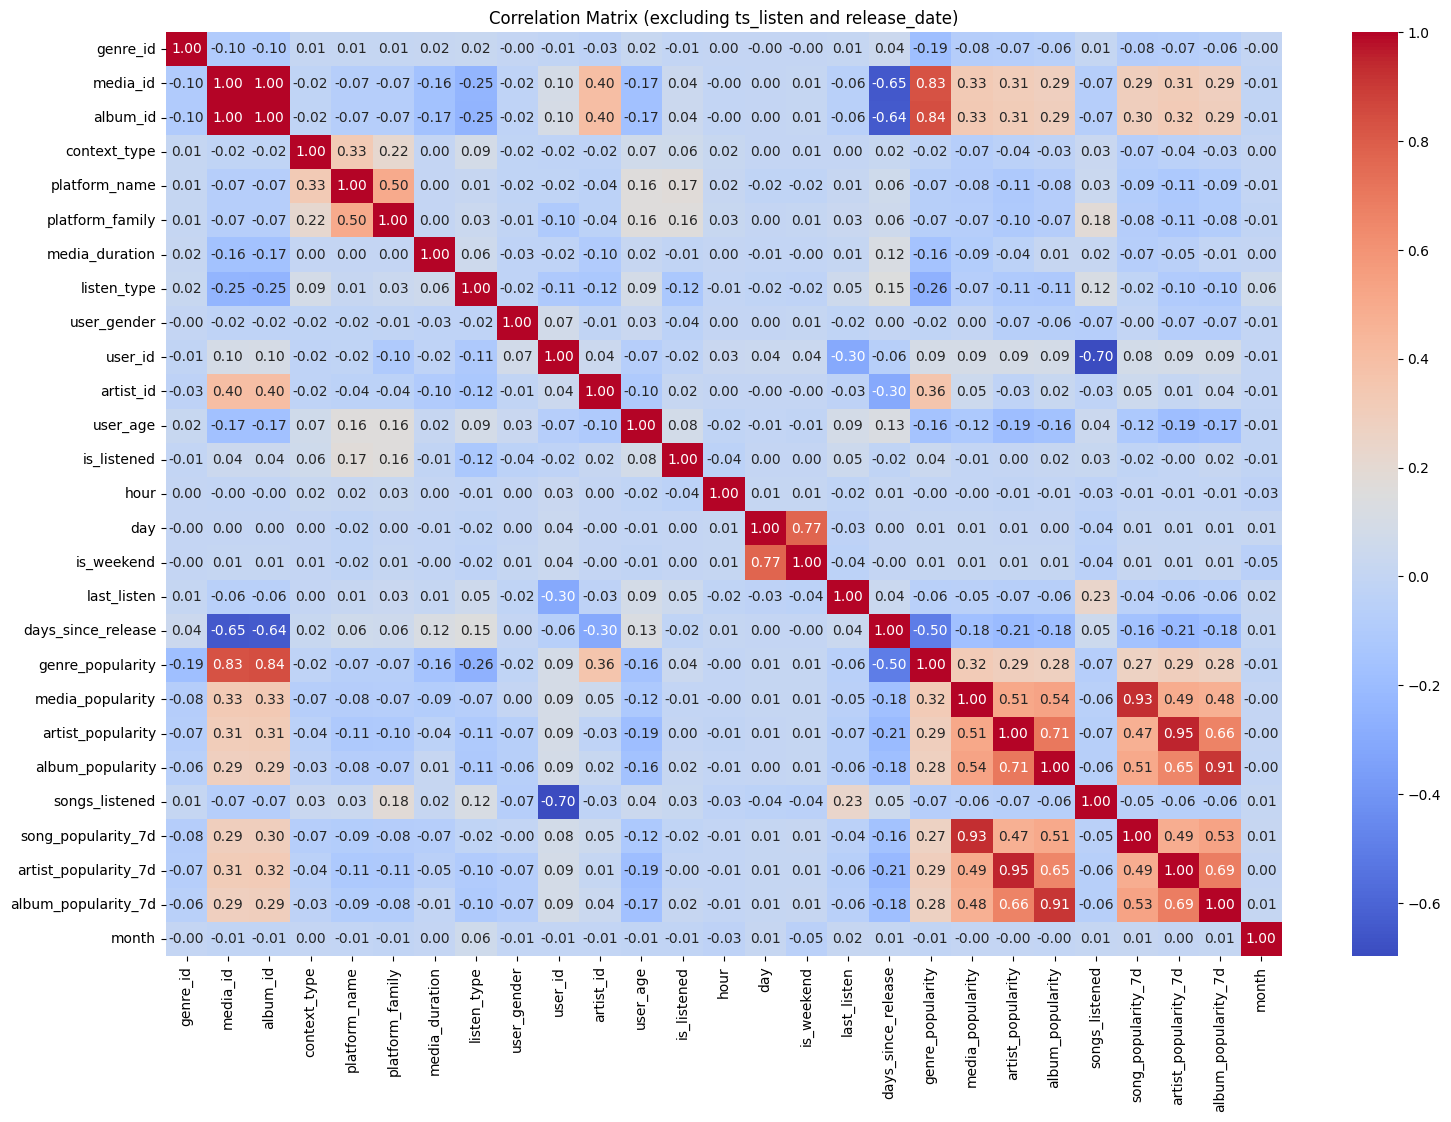

In [3]:
data_corr = data.drop(['ts_listen', 'release_date', 'time_of_day'], axis=1)

plt.figure(figsize=(18, 12))
sns.heatmap(data_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (excluding ts_listen and release_date)")
plt.show()

In [4]:
#Encoding
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
platform_encoder = LabelEncoder()
genre_encoder = LabelEncoder()
artist_encoder = LabelEncoder()


# Fit LabelEncoders on the full range of each categorical variable before train-test split
user_encoder.fit(data["user_id"].unique())
item_encoder.fit(data["media_id"].unique())
gender_encoder.fit(data["user_gender"].unique())
platform_encoder.fit(data["platform_name"].unique())
genre_encoder.fit(data["genre_id"].unique())
artist_encoder.fit(data["artist_id"].unique())


# Transform categorical data
data["user_id"] = user_encoder.transform(data["user_id"])
data["media_id"] = item_encoder.transform(data["media_id"])
data["genre_id"] = genre_encoder.transform(data["genre_id"])
data['user_gender_enc'] = gender_encoder.transform(data['user_gender'])
data['platform_name_enc'] = platform_encoder.transform(data['platform_name'])
data["artist_id_enc"] = artist_encoder.transform(data["artist_id"])

# MinMax scaling to bring it to a 0-1 range
scaler = MinMaxScaler()
data['user_age_scaled'] = scaler.fit_transform(data[['user_age']])
data['song_popularity_7d_scaled'] = scaler.fit_transform(data[['song_popularity_7d']])
data['last_listen_scaled'] = scaler.fit_transform(data[['last_listen']])
data.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,...,song_popularity_7d,artist_popularity_7d,album_popularity_7d,month,user_gender_enc,platform_name_enc,artist_id_enc,user_age_scaled,song_popularity_7d_scaled,last_listen_scaled
0,9,2016-11-12 22:01:41,10134,299421,1,2002-12-31,2,1,198,1,...,0,6,1,11,0,2,440,0.666667,0.000000,0.0
1,271,2016-11-10 02:28:23,7568,224543,0,2005-12-05,0,0,223,0,...,2,46,2,11,0,0,504,0.583333,0.019608,0.0
2,9,2016-11-02 07:41:53,3867,103376,0,2005-08-22,0,0,201,0,...,1,1,1,11,0,0,777,0.500000,0.009804,0.0
3,0,2016-11-24 17:23:28,63304,14101012,0,2016-09-23,0,0,187,0,...,35,81,69,11,0,0,14401,0.833333,0.343137,0.0
4,6,2016-11-11 11:55:23,3932,103798,0,1998-01-07,1,0,264,0,...,7,25,7,11,1,1,684,0.916667,0.068627,0.0


##Train/Test Split

In [5]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

## Create PyTorch dataset

In [6]:
class ListenDataset(Dataset):
    def __init__(self, data):
        self.users = torch.tensor(data['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(data['media_id'].values, dtype=torch.long)
        self.artists = torch.tensor(data['artist_id_enc'].values, dtype=torch.long)
        self.ages = torch.tensor(data['user_age_scaled'].values, dtype=torch.float32)
        self.genders = torch.tensor(data['user_gender_enc'].values, dtype=torch.long)
        self.platforms = torch.tensor(data['platform_name_enc'].values, dtype=torch.long)
        self.song_popularity_7d = torch.tensor(data['song_popularity_7d_scaled'].values, dtype=torch.float32)
        self.last_listen = torch.tensor(data['last_listen_scaled'].values, dtype=torch.float32)
        self.genres = torch.tensor(data['genre_id'].values, dtype=torch.long)
        self.labels = torch.tensor(data['is_listened'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.users[idx],
            self.items[idx],
            self.artists[idx],
            self.ages[idx],
            self.genders[idx],
            self.platforms[idx],
            self.song_popularity_7d[idx],
            self.last_listen[idx],
            self.genres[idx]
        ), self.labels[idx]


## Model Definition

In [24]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items,num_artists, num_genders, num_platforms, emb_size=64):
        super(NCF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.artist_emb = nn.Embedding(num_artists, emb_size)
        self.gender_emb = nn.Embedding(num_genders, emb_size // 2)  # Smaller embedding size for gender
        self.platform_emb = nn.Embedding(num_platforms, emb_size // 2)

        input_dim = emb_size * 3 + (emb_size // 2) * 2 + 4

        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, user, item, artist, age, gender, platform, song_popularity_7d, last_listen, media_id_numeric):
        user_embedded = self.user_emb(user)
        item_embedded = self.item_emb(item)
        gender_embedded = self.gender_emb(gender)
        artist_embedded = self.artist_emb(artist)
        platform_embedded = self.platform_emb(platform)

        # Ensure scalar features are 2D (batch_size, 1)
        age = age.unsqueeze(1)
        song_popularity_7d = song_popularity_7d.unsqueeze(1)
        last_listen = last_listen.unsqueeze(1)
        media_id_numeric = media_id_numeric.unsqueeze(1)

        # Concatenate all features along the last dimension
        x = torch.cat([
            user_embedded,
            item_embedded,
            artist_embedded,
            gender_embedded,
            platform_embedded,
            age,
            song_popularity_7d,
            last_listen,
            media_id_numeric
        ], dim=-1)

        return self.fc_layers(x)


## Initiate Model

In [25]:
# Create DataLoaders from the dataset
train_data = ListenDataset(train)
test_data = ListenDataset(test)
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

# Count unique values for categorical features
num_users = data['user_id'].nunique()
num_items = data['media_id'].nunique()
num_genders = data['user_gender_enc'].nunique()
num_platforms = data['platform_name_enc'].nunique()
num_artists = data['artist_id_enc'].nunique()

# Create the model instance
model = NCF(num_users, num_items, num_artists, num_genders, num_platforms)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  # For binary classification

##Train Model

In [26]:
# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        # Unpack 9 features and the label
        (user, item, artists, age, gender, platform, song_popularity_7d, last_listen, media_id_numeric), label = batch

        # Move tensors to the device
        user = user.to(device)
        item = item.to(device)
        artists = artists.to(device)
        age = age.to(device)
        gender = gender.to(device)
        platform = platform.to(device)
        song_popularity_7d = song_popularity_7d.to(device)
        last_listen = last_listen.to(device)
        media_id_numeric = media_id_numeric.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        preds = model(user, item, artists, age, gender, platform, song_popularity_7d, last_listen, media_id_numeric).squeeze()
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.6036
Epoch 2, Loss: 0.5625
Epoch 3, Loss: 0.5219
Epoch 4, Loss: 0.4958
Epoch 5, Loss: 0.4761
Epoch 6, Loss: 0.4581
Epoch 7, Loss: 0.4429
Epoch 8, Loss: 0.4276
Epoch 9, Loss: 0.4146
Epoch 10, Loss: 0.4032


##Evaluation

In [29]:
import numpy as np

# Set model to evaluation mode
model.eval()

# Variables to collect all predictions, actual labels, user IDs, and media IDs
all_preds = []
all_labels = []
all_users = []
all_items = []

with torch.no_grad():
    for batch in test_loader:
        # Unpack the features and labels
        (user, item, artists, age, gender, platform, song_popularity_7d, last_listen, media_id_numeric), label = batch
        # Move tensors to the device
        user = user.to(device)
        item = item.to(device)
        age = age.to(device)
        gender = gender.to(device)
        platform = platform.to(device)
        song_popularity_7d = song_popularity_7d.to(device)
        last_listen = last_listen.to(device)
        artists = artists.to(device)
        media_id_numeric = media_id_numeric.to(device)
        label = label.to(device)

        # Get model predictions
        preds = model(user, item, artists, age, gender, platform, song_popularity_7d, last_listen, media_id_numeric).squeeze()

        # Store predictions, labels, user ids, and item ids for later evaluation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        all_users.extend(user.cpu().numpy())
        all_items.extend(item.cpu().numpy())

scaler = MinMaxScaler()
all_preds_normalized = scaler.fit_transform(np.array(all_preds).reshape(-1, 1)).flatten()

# Combine all data into a DataFrame
results_df = pd.DataFrame({
    'User ID': user_encoder.inverse_transform(all_users),
    'Media ID': item_encoder.inverse_transform(all_items),
    'Predicted Score': all_preds,
    'Normalized Score': all_preds_normalized,
    'Actual Label': all_labels
})

# Determine the best threshold
best_f1 = 0
best_threshold = 0
thresholds = np.arange(0.1, 1.0, 0.1)

for threshold in thresholds:
    predictions_binary = (all_preds_normalized >= threshold).astype(int)
    f1 = f1_score(all_labels, predictions_binary)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best F1-Score: {best_f1:.4f} at Threshold: {best_threshold:.2f}")

# Filter predictions using the best threshold
filtered_results_df = results_df[results_df['Normalized Score'] >= best_threshold]

Best F1-Score: 0.8190 at Threshold: 0.20


## Recommendation

In [ ]:
# Function to assign stars based on normalized score
def assign_stars(score):
    if score < 0.33:
        return '⭐'
    elif score < 0.66:
        return '⭐⭐'
    else:
        return '⭐⭐⭐'

# Apply star rating to the DataFrame
filtered_results_df['Star Rating'] = filtered_results_df['Normalized Score'].apply(assign_stars)

user_id_to_recommend = 123

# Selecting items for the specific user and sorting by score
user_recommendations = filtered_results_df[filtered_results_df['User ID'] == user_id_to_recommend].sort_values(by='Normalized Score', ascending=False).head(10)

print("\nTop 10 Recommendations for User ID:", user_id_to_recommend)
print(user_recommendations[['Media ID', 'Predicted Score', 'Star Rating']].to_string(index=False))